In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Metric
from tensorflow.keras import backend as K
from keras_tuner import RandomSearch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pointbiserialr
from tqdm import tqdm

from catboost import MultiTargetCustomMetric
from catboost import CatBoostClassifier, Pool

In [2]:
import warnings
warnings.filterwarnings("ignore")

# ЗАГРУЗКА ДАННЫХ

In [3]:
path_1 = 'data/250218.csv'
path_2 = 'data/250219.csv'

data_1 = pd.read_csv(path_1, delimiter=';')
data_2 = pd.read_csv(path_2, delimiter=';')

# data_1 = data_1[data_1['Timestamp'] != 'Timestamp']

In [4]:
print('data_1 stops:', len(data_1[data_1['Timestamp'] == 'Timestamp']))
print('data_2 stops:', len(data_2[data_2['Timestamp'] == 'Timestamp']))

data_1 stops: 16
data_2 stops: 13


In [5]:
data_1.describe()

,Timestamp,Cpu regime,Current failure,Failure code block,Comand_vector #0,Comand_vector #1,Block connection # 0,Block connection # 1,Block connection # 2,Block connection # 3,...,SO Angle 7 2,SO Angle 7 3,SO Angle 8 1,SO Angle 8 2,SO Angle 8 3,Work time PUD,Work time CPU,Automatic flag,Automatic regime,Automatic step
count,4022,4023,4023,4023,4023,4023,4023,4023,4023,4023,...,4023,4023,4023,4023,4023,4023,4023,4023,4023,4023
unique,4007,5,2,2,23,8,10,11,10,9,...,2,2,2,2,2,3,2,2,2,2
top,Timestamp,06,0000000000000000,0000000000000000,0000000000000000,0000000000000011,"100,000 %","100,000 %","100,000 %","100,000 %",...,0000,0000,0000,0000,0000,00013,00000,00,00,00
freq,16,2499,4006,4006,3537,3182,1059,1228,1229,1850,...,4006,4006,4006,4006,4006,2054,4006,4006,4006,4006


In [6]:
data_2.describe()

,Timestamp,Cpu regime,Current failure,Failure code block,Comand_vector #0,Comand_vector #1,Block connection # 0,Block connection # 1,Block connection # 2,Block connection # 3,...,SO Angle 7 2,SO Angle 7 3,SO Angle 8 1,SO Angle 8 2,SO Angle 8 3,Work time PUD,Work time CPU,Automatic flag,Automatic regime,Automatic step
count,9050,9050,9050,9050,9050,9050,9050,9050,9050,9050,...,9050,9050,9050,9050,9050,9050,9050,9050,9050,9050
unique,9038,6,2,2,24,11,11,10,11,10,...,2,2,2,2,2,3,2,2,2,2
top,Timestamp,06,0000000000000000,0000000000000000,0000000000000000,0000000000000000,"100,000 %","100,000 %","100,000 %","100,000 %",...,0000,0000,0000,0000,0000,00013,00000,00,00,00
freq,13,4401,9037,9037,8674,3708,2479,2877,2771,4421,...,9037,9037,9037,9037,9037,4879,9037,9037,9037,9037


In [7]:
def plot_time_periods(df: pd.DataFrame, time_col: str, target_col: str, plots_per_row=2):
    break_points = [0] + df[df[time_col] == 'Timestamp'].index.to_list()
    
    segments = []
    for idx in range(len(break_points) - 1):
        segment = df[break_points[idx] + 1:break_points[idx + 1]]
        segments.append(segment)

    n_segments = len(segments)
    n_rows = (n_segments + plots_per_row - 1) // plots_per_row
    fig_width = 10 * plots_per_row
    fig_height = 3 * n_rows
    fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(fig_width, fig_height))
    axes = axes.flatten()

    
    for i, (segment, ax) in enumerate(zip(segments, axes), 1):
        segment['is_nonzero'] = segment[target_col] != '0' * 16
        segment['is_nonzero'] = segment['is_nonzero'].astype(int)

        ax.step(segment[time_col].index.to_list(), segment['is_nonzero'], where='post', color='blue')
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        
        ax.set_title(f'Период {i}')
        ax.set_xlabel('Время (idx)')
        ax.set_ylabel('0/1')
        ax.set_ylim(-0.1, 1.1)
        ax.set_yticks([0, 1])
        ax.grid(True, linestyle=':')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

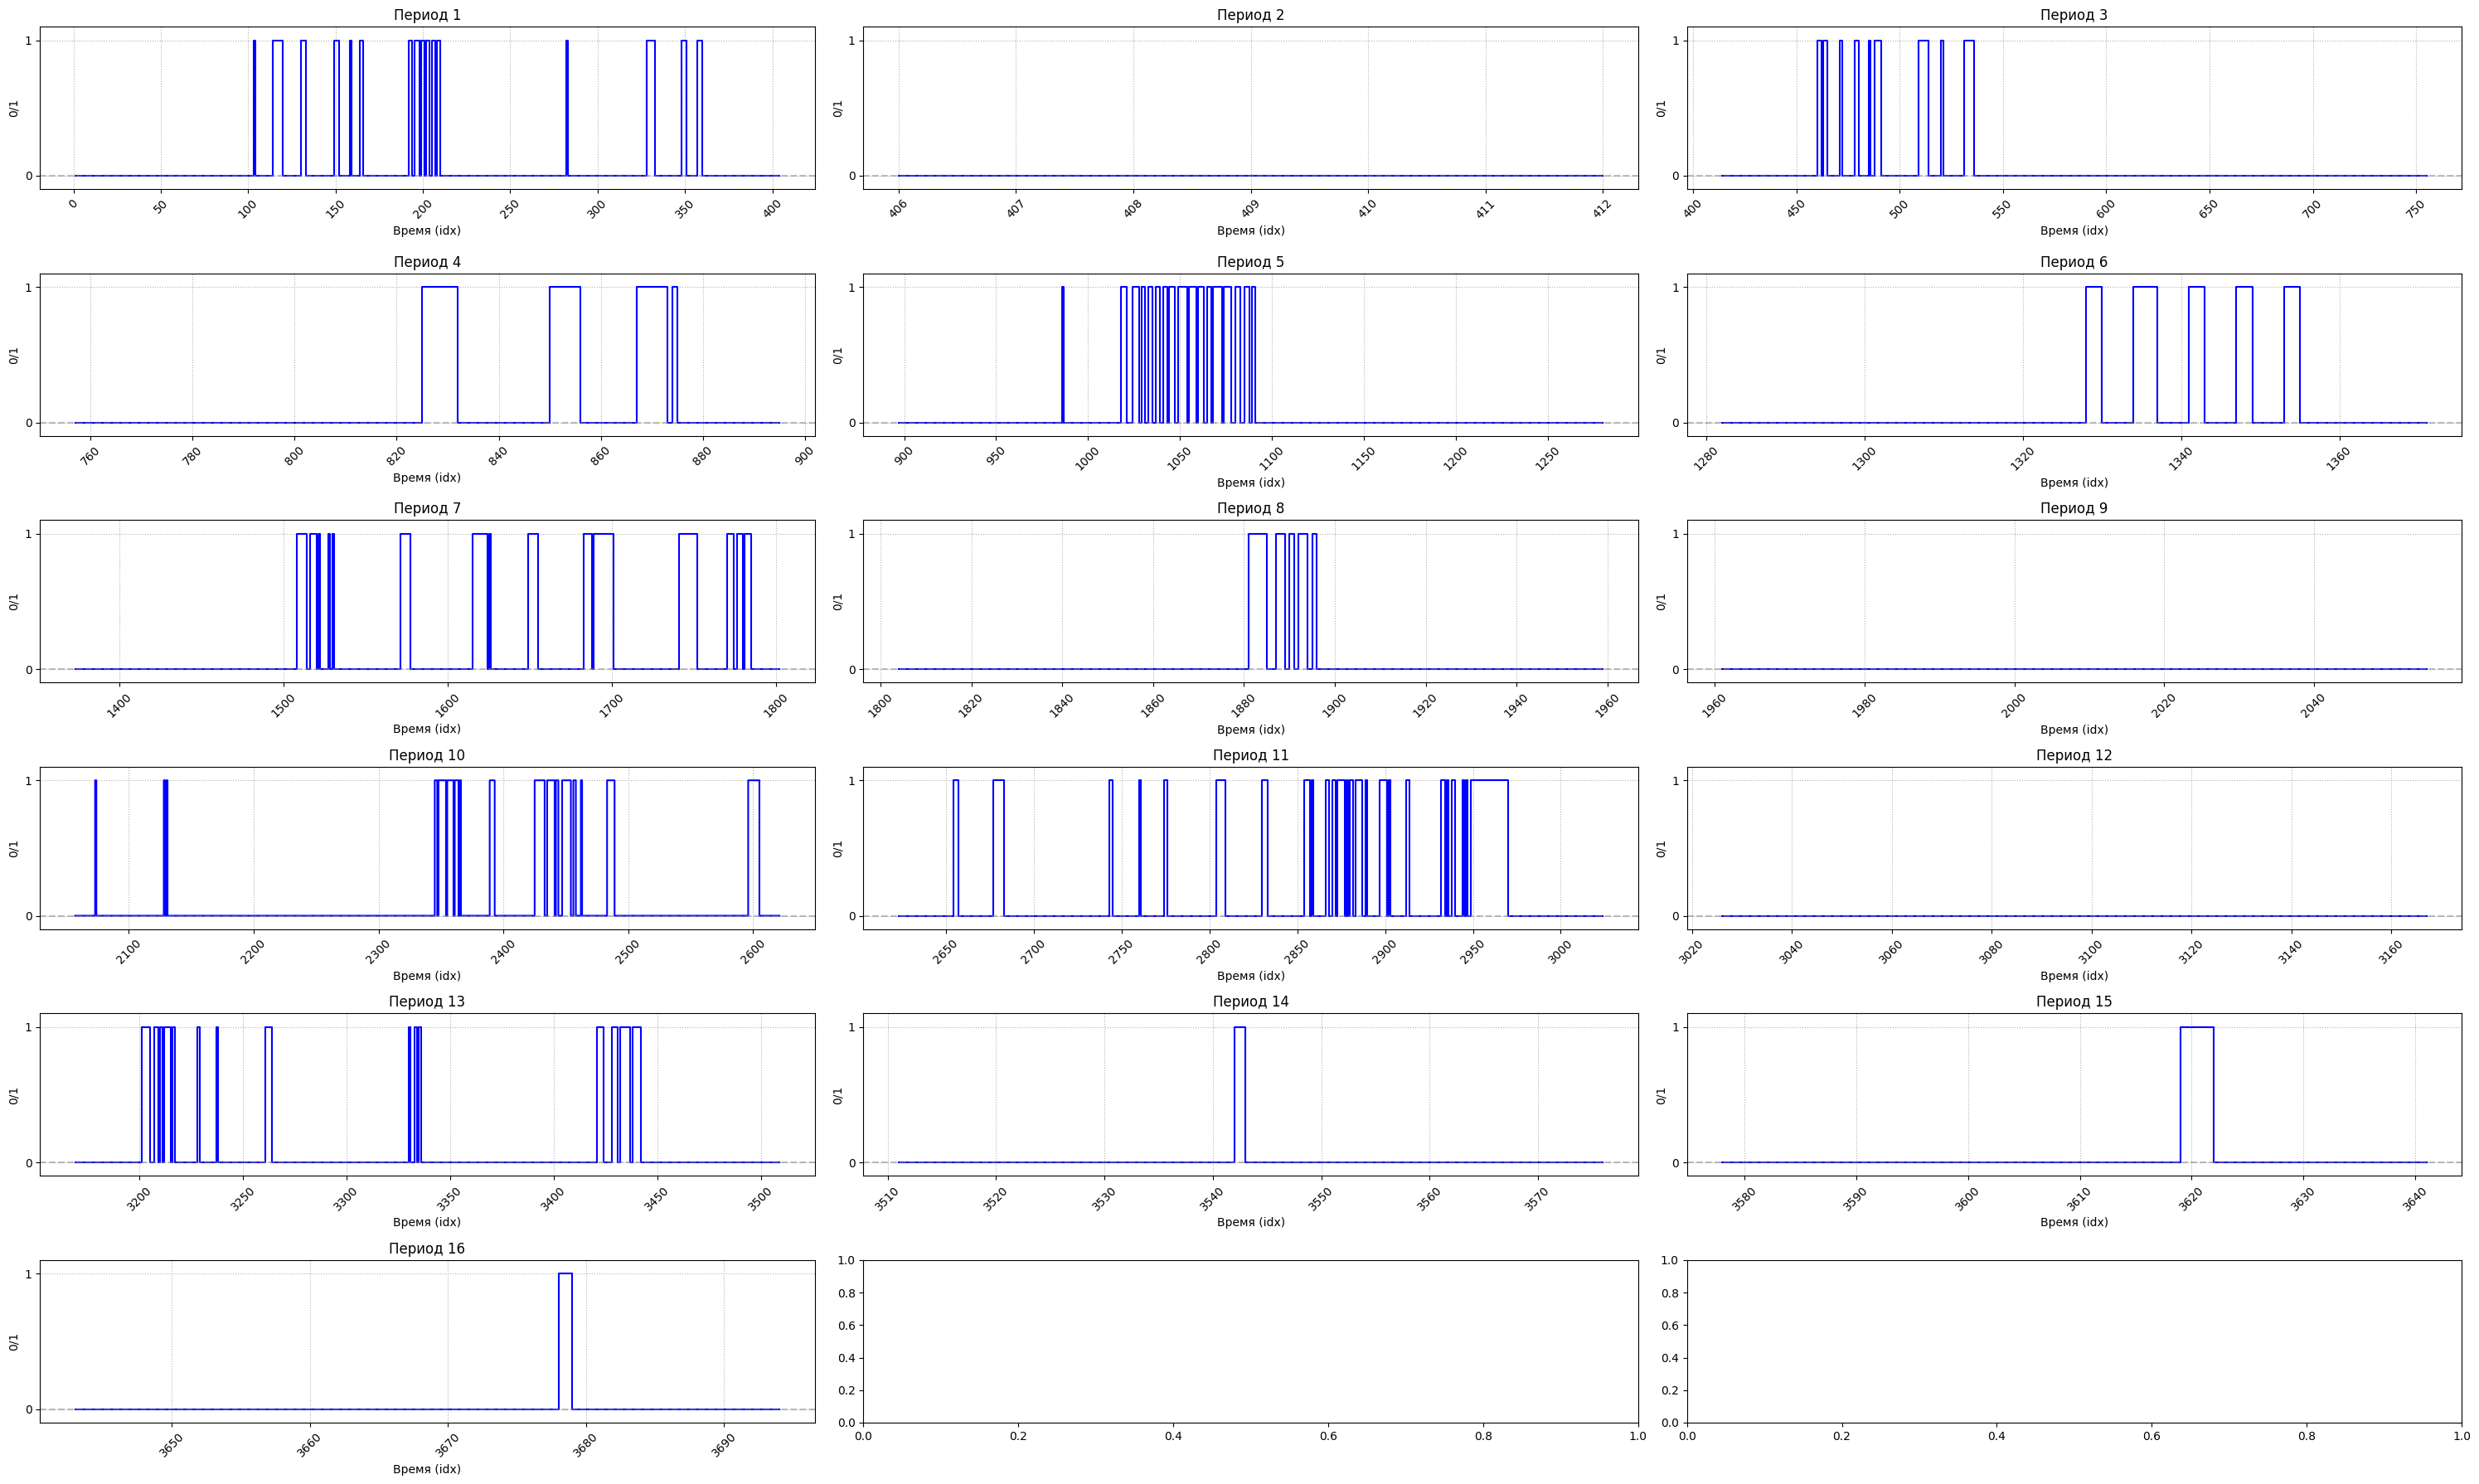

In [8]:
plot_time_periods(data_1, 'Timestamp', 'Comand_vector #0', plots_per_row=3)

In [9]:
def delete_zero_segments(data):
    stops_idx = data[data['Timestamp'] == 'Timestamp'].index.to_list()
    non_zero_dfs = []

    for idx in range(len(stops_idx) - 1):
        segment = data[stops_idx[idx] + 1:stops_idx[idx + 1]]
        if len(segment['Comand_vector #0'].unique()) > 1:
            non_zero_dfs.append(segment)

    new_data = non_zero_dfs[0]
    for i in range(1, len(non_zero_dfs)):
        new_data = pd.concat([new_data, non_zero_dfs[i]], ignore_index=True)
    return new_data

In [10]:
data_1 = delete_zero_segments(data_1)
data_2 = delete_zero_segments(data_2)

In [11]:
command_vector_0_masks = {
    "R1_1": 0x1,
    "R1_2": 0x2,
    "R2_1": 0x4,
    "R2_2": 0x8,
    "R3_1": 0x10,
    "R3_2": 0x20,
    "R4_1": 0x40,
    "R4_2": 0x80,
    "R5_1": 0x100,
    "R5_2": 0x200,
    "R6_1": 0x400,
    "R6_2": 0x800,
    "R7_1": 0x1000,
    "R7_2": 0x2000,
    "R8_1": 0x4000,
    "R8_2": 0x8000,
    "R9_1": 0x10000,
    "R9_2": 0x20000,
    "R10_1": 0x40000,
    "R10_2": 0x80000,
    "R11_1": 0x100000,
    "R11_2": 0x200000,
    "R12_1": 0x400000,
    "R12_2": 0x800000,
    "R13_1": 0x1000000,
    "R13_2": 0x2000000,
    "R14_1": 0x4000000,
    "R14_2": 0x8000000,
    "R15_1": 0x10000000,
    "R15_2": 0x20000000,
    "R16_1": 0x40000000,
    "R16_2": 0x80000000,
    "R17_1": 0x100000000,
    "R17_2": 0x200000000,
    "R18_1": 0x400000000,
    "R18_2": 0x800000000,
    "R19_1": 0x1000000000,
    "R19_2": 0x2000000000,
    "R20_1": 0x4000000000,
    "R20_2": 0x8000000000,
    "R21_1": 0x10000000000,
    "R21_2": 0x20000000000,
    "R22_1": 0x40000000000,
    "R22_2": 0x80000000000,
    "R23_1": 0x100000000000,
    "R23_2": 0x200000000000,
    "R24_1": 0x400000000000,
    "R24_2": 0x800000000000,
    "R25_1": 0x1000000000000,
    "R25_2": 0x2000000000000,
    "R26_1": 0x4000000000000,
    "R26_2": 0x8000000000000,
    "R27_1": 0x10000000000000,
    "R27_2": 0x20000000000000,
    "R28_1": 0x40000000000000,
    "R28_2": 0x80000000000000,
    "R29_1": 0x100000000000000,
    "R29_2": 0x200000000000000,
    "R30_1": 0x400000000000000,
    "R30_2": 0x800000000000000,
    "R31_1": 0x1000000000000000,
    "R31_2": 0x2000000000000000,
    "R32_1": 0x4000000000000000,
    "R32_2": 0x8000000000000000
}
len(command_vector_0_masks)

64

In [12]:
def decode_command_vector(hex_str):
    value = int(hex_str, 16)
    active_commands = []
    for name, mask in command_vector_0_masks.items():
        if value & mask:
            active_commands.append(name)
    return active_commands, [hex(command_vector_0_masks[i]) for i in active_commands]

In [13]:
unique_comand2 = data_2[data_2['Comand_vector #0'] != 'Comand_vector #0']['Comand_vector #0'].unique()

comands2 = []
for i in unique_comand2:
    decoded = decode_command_vector(i)
    # print(f'{i}\n{decoded}\n')
    comands2.extend(decoded[0])

print(sorted(list(set(comands2))))

['R11_1', 'R11_2', 'R12_1', 'R12_2', 'R13_1', 'R13_2', 'R15_1', 'R15_2', 'R3_1', 'R4_1', 'R5_1', 'R6_1', 'R6_2', 'R7_1', 'R7_2', 'R8_1', 'R8_2']


In [14]:
f = lambda hex_str: tuple(decode_command_vector(hex_str)[0])

data_1['decoded_comand #0'] = data_1[data_1['Comand_vector #0'] != 'Comand_vector #0']['Comand_vector #0'].apply(f)
data_2['decoded_comand #0'] = data_2[data_2['Comand_vector #0'] != 'Comand_vector #0']['Comand_vector #0'].apply(f)

In [15]:
pdu_joy_masks = {
    "FORWARD": 0x1000,
    "BACK": 0x2000,
    "LEFT": 0x4000,
    "RIGHT": 0x8000,
    "BTN_LEFT": 0x0100,
    "BTN_RIGHT": 0x0200,
    "L_AFTER_DEV": 0x0400,
    "R_AFRER_DEV": 0x0800,
}

In [16]:
def decode_pdu_joy(hex_str):
    value = int(hex_str, 16)
    data = []
    for name, mask in pdu_joy_masks.items():
        if value & mask:
            data.append(name)
    data.append(value & 0xFF)
    return tuple(data)

In [17]:
btns = lambda hex_str: decode_pdu_joy(hex_str)[:-1] if 'PDU Joy' not in hex_str else ()
dev = lambda hex_str: (decode_pdu_joy(hex_str)[-1]) / 100 if 'PDU Joy' not in hex_str else 0
for i in range(1, 4):
    data_1[f'decoded_joy{i}_btns'] = data_1[f'PDU Joy{i}'].apply(btns)
    data_1[f'deviation_joy{i}'] = data_1[f'PDU Joy{i}'].apply(dev)

    data_2[f'decoded_joy{i}_btns'] = data_2[f'PDU Joy{i}'].apply(btns)
    data_2[f'deviation_joy{i}'] = data_2[f'PDU Joy{i}'].apply(dev)

In [18]:
print(data_1['decoded_joy1_btns'].unique())
print(data_1['decoded_joy2_btns'].unique())
print(data_1['decoded_joy3_btns'].unique())

[() ('LEFT',) ('RIGHT',) ('FORWARD',) ('BACK',)]
[() ('FORWARD',) ('RIGHT',) ('BACK',) ('RIGHT', 'BTN_LEFT')
 ('LEFT', 'BTN_LEFT') ('FORWARD', 'BTN_LEFT') ('BACK', 'BTN_LEFT')]
[()]


In [19]:
print(data_2['decoded_joy1_btns'].unique())
print(data_2['decoded_joy2_btns'].unique())
print(data_2['decoded_joy3_btns'].unique())

[() ('FORWARD',) ('BACK',) ('FORWARD', 'BTN_RIGHT') ('BACK', 'BTN_RIGHT')
 ('BACK', 'BTN_LEFT') ('LEFT',) ('RIGHT',)]
[() ('RIGHT', 'BTN_LEFT') ('FORWARD',) ('LEFT', 'BTN_LEFT') ('BACK',)
 ('FORWARD', 'BTN_RIGHT') ('BACK', 'BTN_RIGHT')]
[()]


one-hot encoding

In [20]:
data_1.at[405, 'decoded_comand #0'] = tuple(command_vector_0_masks.keys())[:30]
data_1.at[405, 'decoded_joy1_btns'] = tuple(pdu_joy_masks.keys())
data_1.at[405, 'decoded_joy2_btns'] = tuple(pdu_joy_masks.keys())
data_1.at[405, 'decoded_joy3_btns'] = tuple(pdu_joy_masks.keys())
# data_1['decoded_comand #0'].unique()

data_2.at[734, 'decoded_comand #0'] = tuple(command_vector_0_masks.keys())[:30]
data_2.at[405, 'decoded_joy1_btns'] = tuple(pdu_joy_masks.keys())
data_2.at[405, 'decoded_joy2_btns'] = tuple(pdu_joy_masks.keys())
data_2.at[405, 'decoded_joy3_btns'] = tuple(pdu_joy_masks.keys())
# data_2['decoded_comand #0'].unique()

In [21]:
mlb1 = MultiLabelBinarizer()
mlb_joy1 = MultiLabelBinarizer()
mlb_joy2 = MultiLabelBinarizer()
mlb_joy3 = MultiLabelBinarizer()


ohe_data_1 = mlb1.fit_transform(data_1['decoded_comand #0'].apply(lambda x: x if isinstance(x, tuple) else ()))
ohe_data_2 = mlb1.fit_transform(data_2['decoded_comand #0'].apply(lambda x: x if isinstance(x, tuple) else ()))

ohe_data_1_joy1 = mlb_joy1.fit_transform(data_1['decoded_joy1_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))
ohe_data_1_joy2 = mlb_joy2.fit_transform(data_1['decoded_joy2_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))
ohe_data_1_joy3 = mlb_joy3.fit_transform(data_1['decoded_joy3_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))

ohe_data_2_joy1 = mlb_joy1.fit_transform(data_2['decoded_joy1_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))
ohe_data_2_joy2 = mlb_joy2.fit_transform(data_2['decoded_joy2_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))
ohe_data_2_joy3 = mlb_joy3.fit_transform(data_2['decoded_joy3_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))

ohe_df1 = pd.DataFrame(ohe_data_1, columns=mlb1.classes_)
ohe_df2 = pd.DataFrame(ohe_data_2, columns=mlb1.classes_)

ohe_df1_joy1 = pd.DataFrame(ohe_data_1_joy1, columns=[f'{col}_Joy1' for col in mlb_joy1.classes_])
ohe_df1_joy2 = pd.DataFrame(ohe_data_1_joy2, columns=[f'{col}_Joy2' for col in mlb_joy2.classes_])
ohe_df1_joy3 = pd.DataFrame(ohe_data_1_joy3, columns=[f'{col}_Joy3' for col in mlb_joy3.classes_])

ohe_df2_joy1 = pd.DataFrame(ohe_data_2_joy1, columns=[f'{col}_Joy1' for col in mlb_joy1.classes_])
ohe_df2_joy2 = pd.DataFrame(ohe_data_2_joy2, columns=[f'{col}_Joy2' for col in mlb_joy2.classes_])
ohe_df2_joy3 = pd.DataFrame(ohe_data_2_joy3, columns=[f'{col}_Joy3' for col in mlb_joy3.classes_])

data_1 = pd.concat([data_1, ohe_df1, ohe_df1_joy1, ohe_df1_joy2, ohe_df1_joy3], axis=1)
data_2 = pd.concat([data_2, ohe_df2, ohe_df2_joy1, ohe_df2_joy2, ohe_df2_joy3], axis=1)

In [22]:
list(data_1.columns)

['Timestamp',
 'Cpu regime',
 'Current failure',
 'Failure code block',
 'Comand_vector #0',
 'Comand_vector #1',
 'Block connection # 0',
 'Block connection # 1',
 'Block connection # 2',
 'Block connection # 3',
 'Block connection # 4',
 'Block connection # 5',
 'Block connection # 6',
 'Block connection # 7',
 'Block connection # 8',
 'Block connection # 9',
 'Block connection # 10',
 'Block connection # 11',
 'Block connection # 12',
 'Block connection # 13',
 'Block connection # 14',
 'Block connection # 15',
 'PDU di buttons',
 'PDU Control',
 'PDU Joy1',
 'PDU Joy2',
 'PDU Joy3',
 'PDU Joy1 buttons',
 'PDU Joy2 buttons',
 'PDU Joy3 buttons',
 'PDU Buttons matrix',
 'HV Motor t*C state',
 'HV Motor t*C',
 'HV Motor state',
 'HV Motor work',
 'HV Riz',
 'HV Uphase',
 'HV Uphase.1',
 'HV Uphase.2',
 'HV Iphase',
 'HV Iphase.1',
 'HV Iphase.2',
 'HV Phasing',
 'HV Phasing.1',
 'HV Phasing.2',
 'DVS Engine t*C state',
 'DVS Engine t*C',
 'DVS Fuel',
 'DVS RPM',
 'DVS Engine state',
 

УДАЛЕНИЕ НЕНУЖНЫХ ФИЧ

In [23]:
columns_to_drop = ['Current failure', 'Failure code block',
                   'HV Motor t*C state',
                   'HV Motor t*C',
                   'HV Motor state',
                   'DVS Engine t*C state',
                   'DVS Engine t*C',
                   'DVS Fuel',
                   'DVS RPM',
                   'DVS Engine state',
                   'DVS Oil pressure',
                   'HIDR Oil level',
                   'Work time PUD',
                   'Work time CPU',
                   'Automatic flag',
                   'Automatic regime',
                   'Automatic step',
                   'Timestamp',
                   'Comand_vector #0',
                   'Comand_vector #1',
                   'PDU Joy1',
                   'PDU Joy2',
                   'PDU Joy3',
                   'decoded_comand #0',
                   'decoded_joy1_btns',
                   'decoded_joy2_btns',
                   'decoded_joy3_btns',                   
]
for i in range(7, 16):
    columns_to_drop.append(f'Block connection # {i}')

for i in range(2, 17):
    columns_to_drop.append(f'HIDR RD{i}')

for i in range(5, 9):
    for j in range(1, 4):
        columns_to_drop.append(f'SO Angle {i} {j}')

len(columns_to_drop)

63

In [24]:
data_1 = data_1.drop(columns=columns_to_drop)
data_2 = data_2.drop(columns=columns_to_drop)

In [25]:
len(list(data_1.columns))

100

In [26]:
def convert_fun(x):
    try:
        return float(x.replace(',', '.'))
    except Exception:
        return x

def convert_col(col_name):
    data_1[col_name] = data_1[col_name].apply(convert_fun)
    data_2[col_name] = data_2[col_name].apply(convert_fun)


to_float_cols = [
    'HV Iphase',
    'HV Iphase.1',
    'HV Iphase.2',
    'HV Uphase',
    'HV Uphase.1',
    'HV Uphase.2',
    'HV Phasing',
    'HV Phasing.1',
    'HV Phasing.2',
    'HIDR t*C',
    'Electric Upow',
    'Electric Ucpu',
    'Electric Ifull',
]

for i in range(1, 5):
    for j in range(1, 4):
        to_float_cols.append(f'SO Angle {i} {j}')

for col in to_float_cols:
    convert_col(col)

for i in range(7):
    data_1[f'Block connection # {i}'] = data_1[f'Block connection # {i}'].apply(lambda x: float(x[:-2].replace(',', '.')) / 100 if 'Block' not in x else x)
    data_2[f'Block connection # {i}'] = data_2[f'Block connection # {i}'].apply(lambda x: float(x[:-2].replace(',', '.')) / 100 if 'Block' not in x else x)

data_1['PDU Buttons matrix'] = data_1['PDU Buttons matrix'].apply(lambda x: int(x, 16) if 'PDU' not in x else x)
data_2['PDU Buttons matrix'] = data_2['PDU Buttons matrix'].apply(lambda x: int(x, 16) if 'PDU' not in x else x)

In [27]:
def transform_categorical(col_name):
    unique_1 = [i for i in data_1[col_name].unique() if i != col_name]
    unique_2 = [i for i in data_2[col_name].unique() if i != col_name]

    sl1 = {i: j for i, j in zip(sorted(unique_1), range(len(unique_1)))}
    sl2 = {i: j for i, j in zip(sorted(unique_2), range(len(unique_2)))}

    data_1[col_name] = data_1[col_name].apply(lambda x: sl1[x] if x in sl1 else x)
    data_2[col_name] = data_2[col_name].apply(lambda x: sl2[x] if x in sl2 else x)


categorical_cols = [
    'Cpu regime',
    'PDU di buttons',
    'PDU Control',
    'PDU Joy1 buttons',
    'PDU Joy2 buttons',
    'PDU Joy3 buttons',
    'HV Motor work',
    'HV Riz',
    'HIDR t*C state',
    'HIDR RD1',    
]

for col in categorical_cols:
    transform_categorical(col)

In [28]:
for i in range(1, 5):
    for j in range(1, 4):
        data_1['is_section'] = data_1[f'SO Angle {i} {j}'].apply(lambda x: isinstance(x, str))
        data_2['is_section'] = data_2[f'SO Angle {i} {j}'].apply(lambda x: isinstance(x, str))

        data_1['group'] = data_1['is_section'].cumsum()
        data_2['group'] = data_2['is_section'].cumsum()

        data_1['numeric_values'] = pd.to_numeric(data_1[f'SO Angle {i} {j}'], errors='coerce')
        data_2['numeric_values'] = pd.to_numeric(data_2[f'SO Angle {i} {j}'], errors='coerce')

        data_1[f'Delta_angle_{i} {j}'] = data_1.groupby('group')['numeric_values'].transform(
            lambda x: x.diff() if x.notna().any() else np.nan
        )
        data_2[f'Delta_angle_{i} {j}'] = data_2.groupby('group')['numeric_values'].transform(
            lambda x: x.diff() if x.notna().any() else np.nan
        )

        data_1.loc[data_1['is_section'], f'Delta_angle_{i} {j}'] = np.nan
        data_2.loc[data_2['is_section'], f'Delta_angle_{i} {j}'] = np.nan

        data_1 = data_1.drop(columns=[f'SO Angle {i} {j}', 'is_section', 'group', 'numeric_values'])
        data_2 = data_2.drop(columns=[f'SO Angle {i} {j}', 'is_section', 'group', 'numeric_values'])

In [29]:
for i in range(1, 5):
    for j in range(1, 4):
        col_name = f'Delta_angle_{i} {j}'

        data_1 = data_1[abs(data_1[col_name]) < 30]
        data_2 = data_2[abs(data_2[col_name]) < 30]

In [30]:
data_1

,Cpu regime,Block connection # 0,Block connection # 1,Block connection # 2,Block connection # 3,Block connection # 4,Block connection # 5,Block connection # 6,PDU di buttons,PDU Control,...,Delta_angle_1 3,Delta_angle_2 1,Delta_angle_2 2,Delta_angle_2 3,Delta_angle_3 1,Delta_angle_3 2,Delta_angle_3 3,Delta_angle_4 1,Delta_angle_4 2,Delta_angle_4 3
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0.97,0.95,0.99,0.97,0.99,0.99,0.97,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.97,0.95,0.99,0.97,0.99,0.99,0.97,0,0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,1,0.97,1.0,0.99,0.98,0.98,0.98,0.99,1,0,...,0.0,4.0,-15.0,0.0,8.0,6.0,0.0,11.0,-2.0,0.0
3027,1,0.97,1.0,0.99,0.98,0.98,0.98,0.99,1,0,...,0.0,-3.0,0.0,0.0,12.0,5.0,0.0,-10.0,6.0,0.0
3028,1,0.97,1.0,0.99,0.98,0.98,0.98,0.99,1,0,...,0.0,-7.0,14.0,0.0,2.0,-1.0,0.0,-2.0,-3.0,0.0
3029,1,0.97,1.0,0.99,0.98,0.98,0.98,0.99,1,0,...,0.0,1.0,8.0,0.0,-9.0,-5.0,0.0,12.0,-3.0,0.0


In [31]:
data_2

,Cpu regime,Block connection # 0,Block connection # 1,Block connection # 2,Block connection # 3,Block connection # 4,Block connection # 5,Block connection # 6,PDU di buttons,PDU Control,...,Delta_angle_1 3,Delta_angle_2 1,Delta_angle_2 2,Delta_angle_2 3,Delta_angle_3 1,Delta_angle_3 2,Delta_angle_3 3,Delta_angle_4 1,Delta_angle_4 2,Delta_angle_4 3
1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.97,0.98,1.00,1.00,0.00,0.99,0.98,0,0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
5,0,0.97,0.98,1.00,1.00,0.94,0.99,0.98,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871,2,1.00,0.98,1.00,1.00,0.99,1.00,0.99,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4872,2,1.00,0.98,1.00,1.00,0.99,1.00,0.99,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4873,2,1.00,0.98,1.00,0.99,0.99,1.00,0.99,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4874,2,1.00,0.98,1.00,0.99,0.99,1.00,0.99,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# ВИЗУАЛИЗАЦИЯ

In [32]:
target_columns = [col for col in data_1.columns if col[0] == 'R' and 'Joy' not in col]

feature_columns = [col for col in  data_1.columns if col not in target_columns]

correlations = data_1[feature_columns].corrwith(data_1[target_columns[0]])
for target in target_columns[1:]:
    correlations = pd.concat([correlations, data_1[feature_columns].corrwith(data_1[target])], axis=1)

correlations.columns = target_columns

In [33]:
for target in target_columns:
    data_1[target] = pd.to_numeric(data_1[target], errors='coerce').fillna(0).astype(int)

for feature in feature_columns:
    if not np.issubdtype(data_1[feature].dtype, np.number):
        try:
            data_1[feature] = pd.to_numeric(data_1[feature], errors='coerce')
        except:
            continue
        
data_1 = data_1.fillna(0)

In [34]:
for target in target_columns:
    data_2[target] = pd.to_numeric(data_2[target], errors='coerce').fillna(0).astype(int)

for feature in feature_columns:
    if not np.issubdtype(data_2[feature].dtype, np.number):
        try:
            data_2[feature] = pd.to_numeric(data_2[feature], errors='coerce')
        except:
            continue
        
data_2 = data_2.fillna(0)

Point biserial

In [35]:
data = pd.concat([data_1, data_2])

In [36]:
pbs_corrs = pd.DataFrame(index=feature_columns, columns=target_columns)

for target in target_columns:
    for feature in feature_columns:
        if np.issubdtype(data[feature].dtype, np.number) and np.issubdtype(data[target].dtype, np.number):
            try:
                corr, _ = pointbiserialr(data[feature], data[target])
                pbs_corrs.loc[feature, target] = corr
            except:
                pbs_corrs.loc[feature, target] = np.nan
        else:
            pbs_corrs.loc[feature, target] = np.nan

pbs_corrs = pbs_corrs.dropna(how='all', axis=0).dropna(how='all', axis=1)

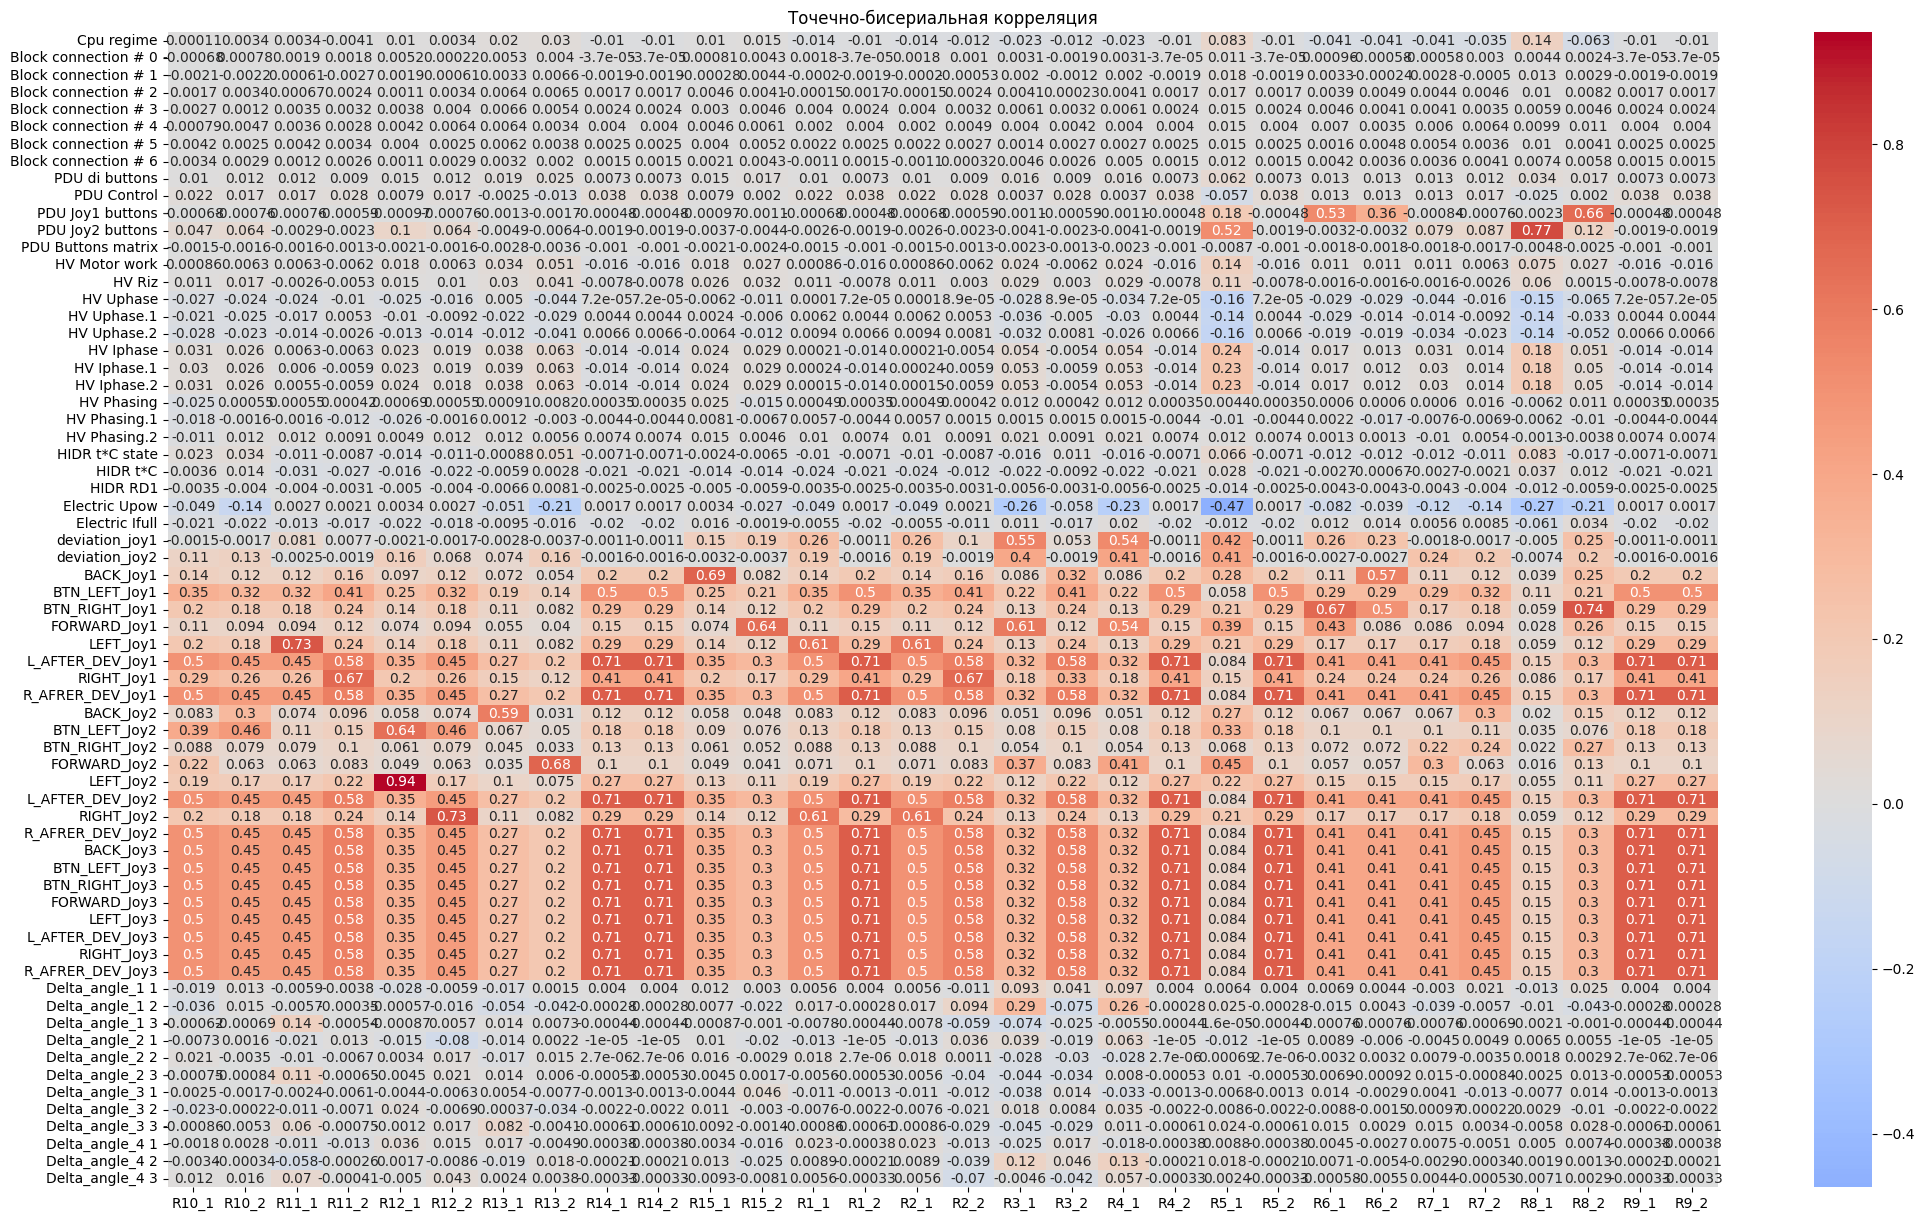

In [37]:
plt.figure(figsize=(25, 15))
sns.heatmap(pbs_corrs.astype(float), annot=True, cmap='coolwarm', center=0)
plt.title("Точечно-бисериальная корреляция")
plt.show()

In [38]:
selected_features_corr = []

for i in range(len(pbs_corrs)):
    if any([abs(corr) >= 0.58 for corr in pbs_corrs.iloc[i]]):
        selected_features_corr.append(i)

In [39]:
selected_features_corr = list(pbs_corrs.iloc[selected_features_corr].index)

In [40]:
len(selected_features_corr)

24

Mutual information

In [ ]:
mi_scores = pd.DataFrame(index=feature_columns, columns=target_columns)

X = data[feature_columns]

for y_col in tqdm(target_columns):
    scores = mutual_info_classif(X, data[y_col], random_state=42)
    mi_scores[y_col] = scores

100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


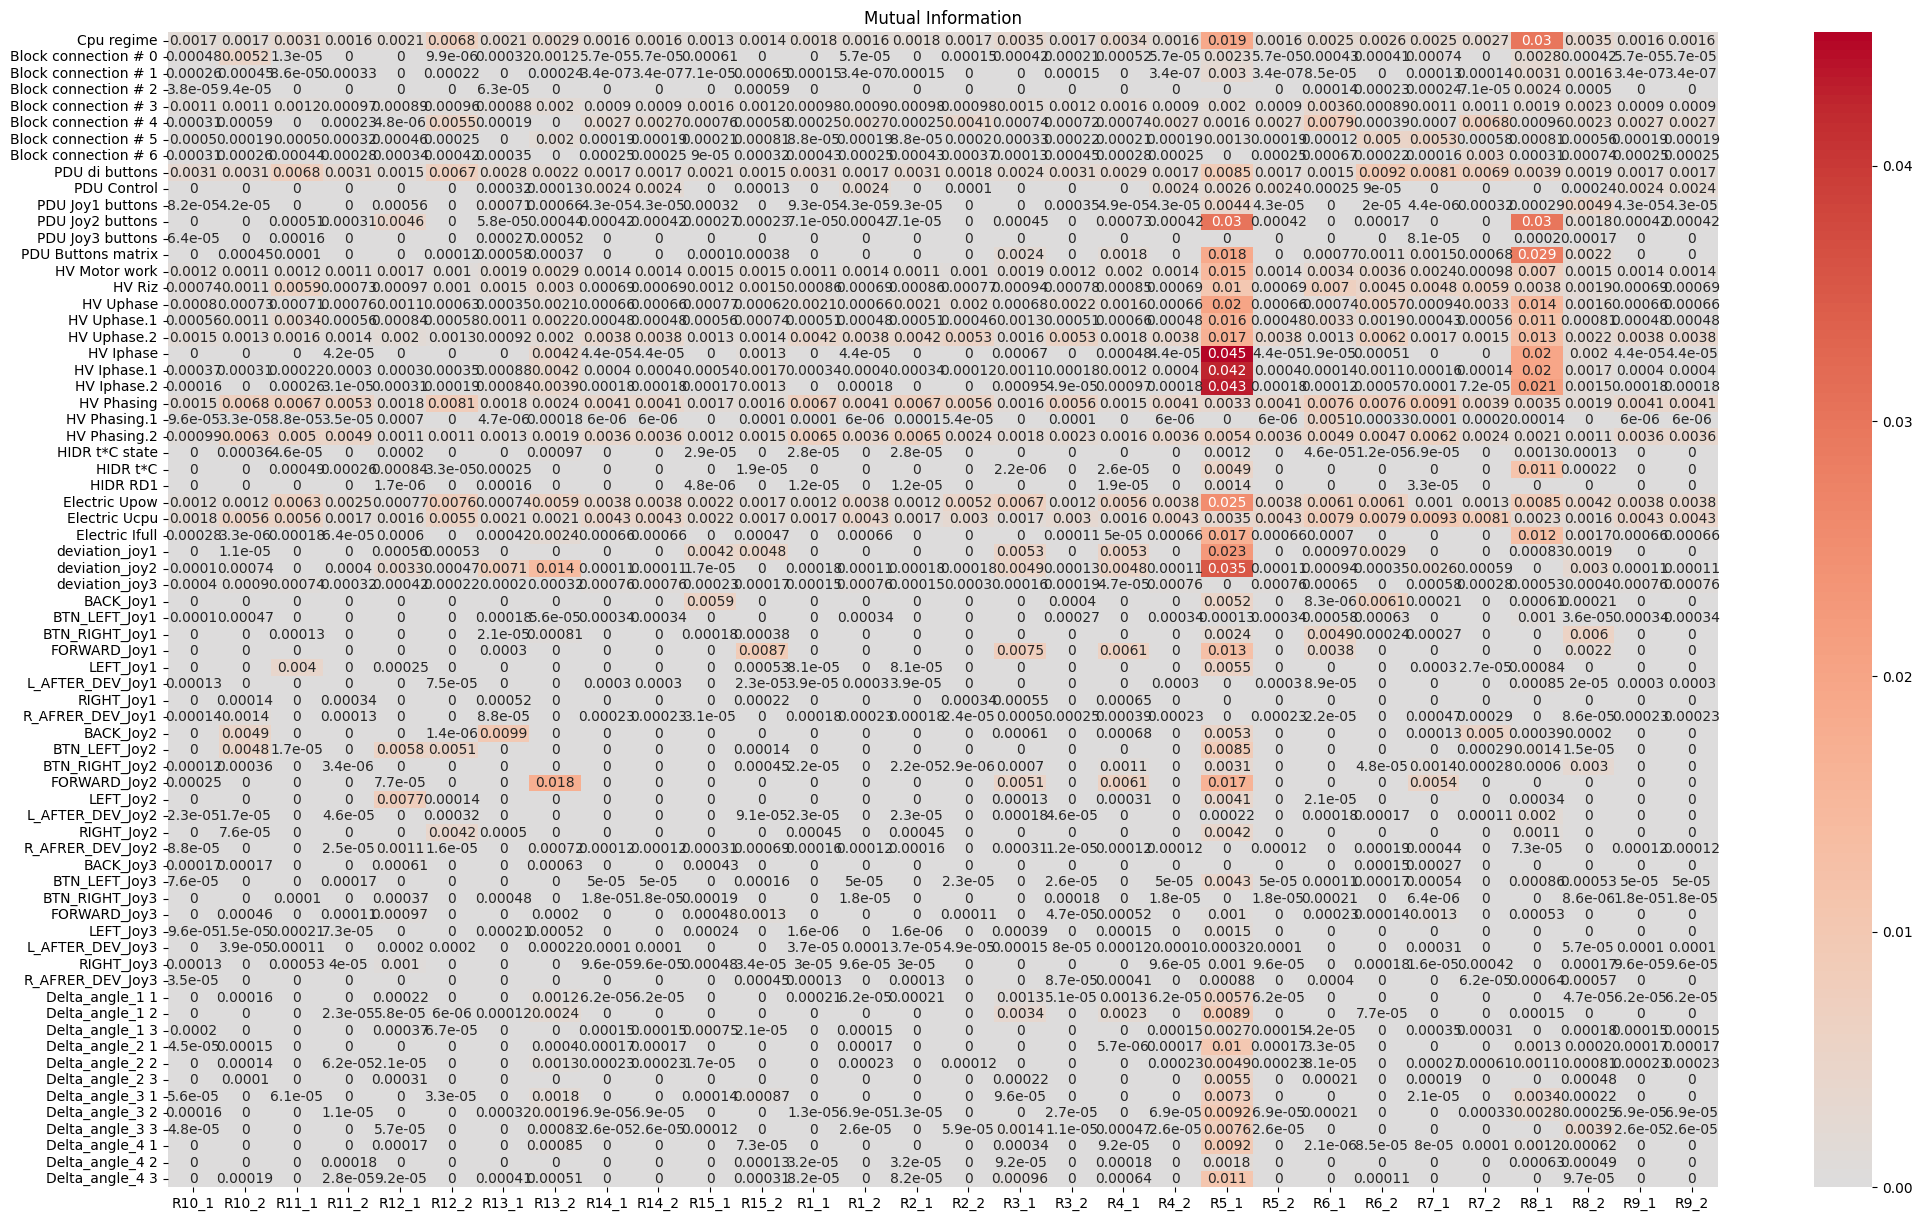

In [252]:
plt.figure(figsize=(25, 15))
sns.heatmap(mi_scores.astype(float), annot=True, cmap='coolwarm', center=0)
plt.title("Mutual Information")
plt.show()

Нормализация + PCA

In [41]:
data = pd.concat([data_1, data_2])

In [42]:
scaler = StandardScaler()

data_scaled = scaler.fit_transform(data[feature_columns])
data_scaled

array([[ -1.81477202, -10.22859186, -10.15456687, ...,  -0.02230852,
         -0.01264121,  -0.01982865],
       [ -1.81477202, -10.22859186, -10.15456687, ...,  -0.02230852,
         -0.01264121,  -0.01982865],
       [ -1.81477202, -10.22859186, -10.15456687, ...,  -0.02230852,
         -0.01264121,  -0.01982865],
       ...,
       [  0.61090823,   0.26002086,   0.04385683, ...,  -0.02230852,
         -0.01264121,  -0.01982865],
       [  0.61090823,   0.26002086,   0.04385683, ...,  -0.02230852,
         -0.01264121,  -0.01982865],
       [  0.61090823,   0.05024861,   0.04385683, ...,  -0.02230852,
         -0.01264121,  -0.01982865]])

In [43]:
pca = PCA()

data_pca = pca.fit_transform(data_scaled)
evr = pca.explained_variance_ratio_
cvr = np.cumsum(evr)
print(evr, cvr)

[2.07482081e-01 1.02306681e-01 8.40176934e-02 4.51219102e-02
 4.21749620e-02 3.68842629e-02 3.30209655e-02 2.85928941e-02
 2.48266354e-02 2.44348651e-02 2.28808302e-02 2.14764692e-02
 2.00159987e-02 1.77795596e-02 1.70448423e-02 1.58761723e-02
 1.57959859e-02 1.56341346e-02 1.44401161e-02 1.39981637e-02
 1.33511756e-02 1.27460383e-02 1.25239693e-02 1.17365323e-02
 1.07955722e-02 9.79680932e-03 9.72976497e-03 9.36025747e-03
 9.19605977e-03 8.97297101e-03 8.66883010e-03 8.65291914e-03
 8.31385436e-03 8.10239445e-03 6.67924625e-03 6.59707036e-03
 6.37443394e-03 5.73821594e-03 5.62995376e-03 4.09338177e-03
 3.09443804e-03 2.66369369e-03 2.52994142e-03 2.39400380e-03
 2.06757156e-03 2.01385598e-03 1.32812499e-03 1.01876751e-03
 7.51896606e-04 4.85583953e-04 3.18296628e-04 2.37017534e-04
 2.22484939e-04 6.02770664e-06 3.62197622e-06 1.11463096e-17
 9.69002500e-18 7.95072859e-18 7.59975743e-18 3.81311365e-18
 2.78741808e-18 2.10210027e-18 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [44]:
n_components = np.argmax(cvr >= 0.9) + 1
n_components

29

In [45]:
pca = PCA(n_components=n_components)
data_reduced = pca.fit_transform(data_scaled)
print(data.shape[1], data_reduced.shape[1])

100 29


In [46]:
pbs_corrs = pd.DataFrame(index=feature_columns, columns=target_columns)

for target in target_columns:
    for i in range(data_reduced.shape[1]):
        if np.issubdtype(data_reduced[:,i].dtype, np.number) and np.issubdtype(data[target].dtype, np.number):
            try:
                corr, _ = pointbiserialr(data_reduced[:,i], data[target])
                pbs_corrs.loc[str(i), target] = corr
            except:
                pbs_corrs.loc[str(i), target] = np.nan
        else:
            pbs_corrs.loc[str(i), target] = np.nan

pbs_corrs = pbs_corrs.dropna(how='all', axis=0).dropna(how='all', axis=1)

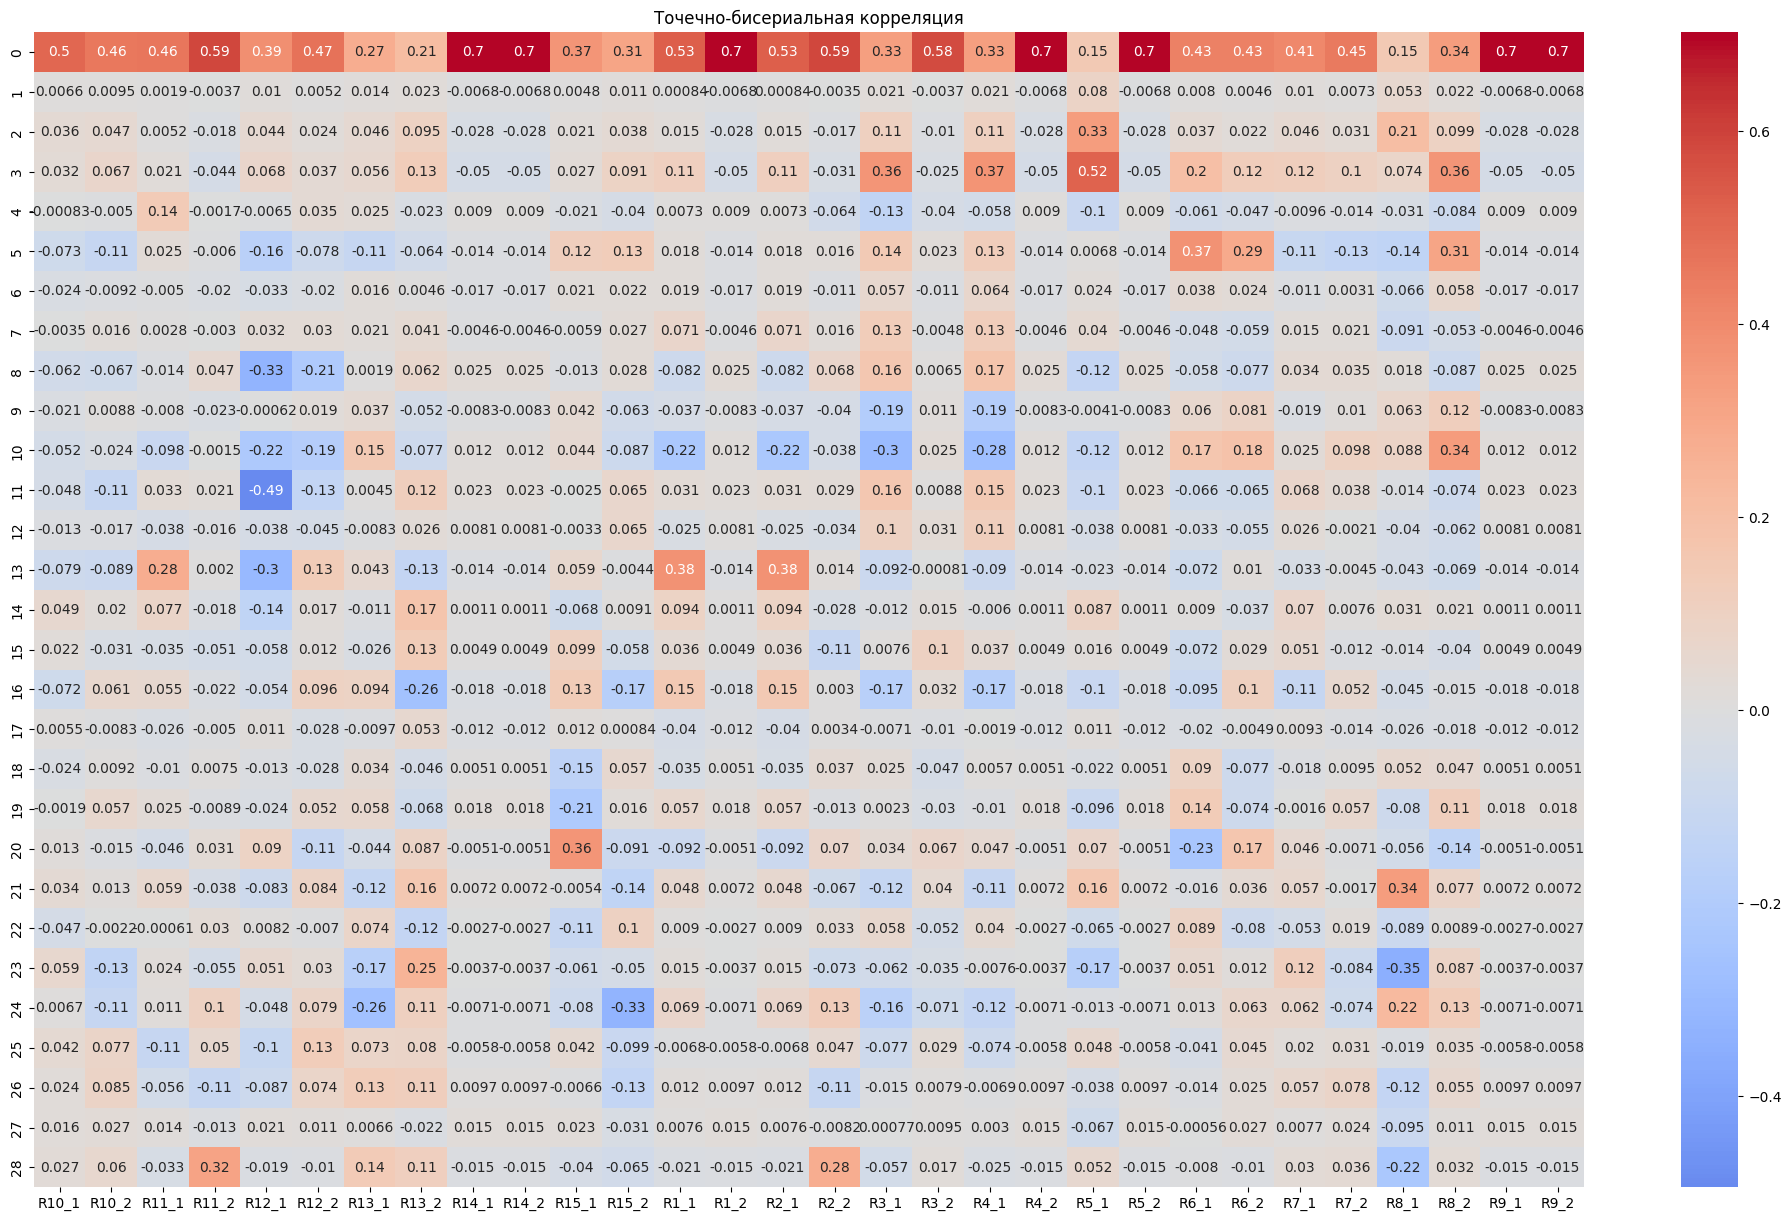

In [47]:
plt.figure(figsize=(25, 15))
sns.heatmap(pbs_corrs.astype(float), annot=True, cmap='coolwarm', center=0)
plt.title("Точечно-бисериальная корреляция")
plt.show()

# ОТБОР ФИЧ (CATBOOST)

In [48]:
class CustomMultiLabelMetric(MultiTargetCustomMetric):
    def __init__(self):
        self._name = 'CustomF1'
        
        self._greater_is_better = True

    def evaluate(self, approxes, targets, weights):
        preds = [np.array(a > 0.5, dtype=int) for a in approxes]
        targets = [np.array(t, dtype=int) for t in targets]
        
        f1_scores = []
        for pred, target in zip(preds, targets):
            tp = np.sum((pred == 1) & (target == 1))
            fp = np.sum((pred == 1) & (target == 0))
            fn = np.sum((pred == 0) & (target == 1))
            
            precision = tp / (tp + fp + 1e-9)
            recall = tp / (tp + fn + 1e-9)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
            f1_scores.append(f1)
        
        return np.mean(f1_scores), len(targets[0])

    def is_max_optimal(self):
        return self._greater_is_better

    def get_final_error(self, error, weight):
        return error


# MODELLING

Catboost

In [40]:
selected_features1 = ['Cpu regime', 'Block connection # 0', 'Block connection # 1', 'Block connection # 4', 'Block connection # 5', 'Block connection # 6', 'PDU Joy2 buttons', 'PDU Buttons matrix', 'HV Uphase', 'HV Uphase.1', 'HV Uphase.2', 'HV Iphase', 'HV Iphase.1', 'HV Iphase.2', 'HV Phasing.2', 'HIDR t*C', 'Electric Upow', 'Electric Ucpu', 'Electric Ifull', 'deviation_joy1', 'deviation_joy2', 'BACK_Joy1', 'FORWARD_Joy1', 'LEFT_Joy1', 'RIGHT_Joy1', 'R_AFRER_DEV_Joy1', 'BACK_Joy2', 'BTN_LEFT_Joy2', 'FORWARD_Joy2', 'LEFT_Joy2', 'L_AFTER_DEV_Joy2', 'RIGHT_Joy2', 'BACK_Joy3', 'FORWARD_Joy3', 'Delta_angle_1 1', 'Delta_angle_2 2', 'Delta_angle_2 3', 'Delta_angle_3 1', 'Delta_angle_4 1', 'Delta_angle_4 2']
selected_features2 = ['Cpu regime', 'Block connection # 4', 'Block connection # 5', 'PDU Joy2 buttons', 'PDU Buttons matrix', 'HV Uphase.1', 'HV Iphase', 'HV Iphase.1', 'HV Iphase.2', 'HIDR t*C', 'Electric Upow', 'deviation_joy1', 'deviation_joy2', 'BACK_Joy1', 'FORWARD_Joy1', 'LEFT_Joy1', 'RIGHT_Joy1', 'R_AFRER_DEV_Joy1', 'BACK_Joy2', 'BTN_LEFT_Joy2', 'FORWARD_Joy2', 'LEFT_Joy2', 'RIGHT_Joy2', 'BTN_LEFT_Joy3', 'FORWARD_Joy3', 'Delta_angle_1 1', 'Delta_angle_2 2', 'Delta_angle_2 3', 'Delta_angle_4 1', 'Delta_angle_4 2']

In [54]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

"""X = data_1[selected_features1]"""
"""y = np.array(data_1[target_columns])"""

tscv = TimeSeriesSplit(n_splits=4)

In [42]:
model_final = CatBoostClassifier(
    iterations=10000,
    learning_rate=1e-3,
    depth=3,
    verbose=0,
    loss_function='MultiLogloss',
    eval_metric=CustomMultiLabelMetric()
)

In [45]:
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_pool = Pool(X_train, y_train)
    test_pool = Pool(X_test, y_test)

    try:
        model_final.fit(train_pool, eval_set=test_pool)
        print(f"Test Score: {model_final.best_score_['validation']['CustomMultiLabelMetric']}")
    except:
        continue

Test Score: 0.21914255662028406
Test Score: 0.3453331249611544
Test Score: 0.22699389485473942
Test Score: 0.30832955957161357


TF LSTM

In [49]:
X = data_reduced
y = data[target_columns].to_numpy()

In [50]:
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [51]:
def create_sequences(data_X, data_y, seq_length):
    X, y = [], []

    for i in range(len(data_X) - seq_length):
        X.append(data_X[i:i + seq_length])
        y.append(data_y[i:i + seq_length])
    
    return np.array(X), np.array(y)

In [52]:
seq_length = 64

X_tf, y_tf = create_sequences(X, y, seq_length)

print(f'X shape: {X_tf.shape}\ny shape: {y_tf.shape}')

X shape: (6962, 64, 29)
y shape: (6962, 64, 30)


In [57]:
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf, test_size=0.3, shuffle=False)

Only high corr targets

In [56]:
def calculate_f1_per_target(y_true, y_pred, target_names=None, average='macro', threshold=0.5):
    y_pred_binary = (y_pred > threshold).astype(int)
    
    if target_names is None:
        target_names = [f'target_{i}' for i in range(y_true.shape[2])]
    else:
        assert len(target_names) == y_true.shape[2], f"Target names assert error target_names: {len(target_names)} != y_shape: {y_true.shape[2]}"
    
    results = {}
    for i, name in enumerate(target_names):
        true_single = y_true[:, :, i].reshape(-1)
        pred_single = y_pred_binary[:, :, i].reshape(-1)
        
        try:
            f1 = f1_score(true_single, pred_single, average=average, zero_division=0)
            results[name] = f1
        except ValueError as e:
            print(f"Ошибка для {name}: {str(e)}")
            results[name] = np.nan
    
    return results

In [65]:
model_tf_corr = Sequential()

model_tf_corr.add(Input((seq_length, X_tf.shape[2])))
model_tf_corr.add(LSTM(128, return_sequences=True, activation='sigmoid'))
model_tf_corr.add(Dropout(0.5))
model_tf_corr.add(LSTM(96, return_sequences=True, activation='sigmoid'))
model_tf_corr.add(Dropout(0.5))
model_tf_corr.add(Dense(30, activation='tanh'))

In [66]:
model_tf_corr.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=[F1Score()])

In [67]:
model_tf_corr.fit(X_tf_train, y_tf_train, epochs=150, validation_data=(X_tf_test, y_tf_test))

Epoch 1/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - f1_score: 0.0019 - loss: 0.0562 - val_f1_score: 0.0000e+00 - val_loss: 0.0018
Epoch 2/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - f1_score: 0.0000e+00 - loss: 0.0368 - val_f1_score: 0.0000e+00 - val_loss: 0.0018
Epoch 3/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - f1_score: 0.0000e+00 - loss: 0.0383 - val_f1_score: 0.0000e+00 - val_loss: 0.0018
Epoch 4/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - f1_score: 0.0000e+00 - loss: 0.0384 - val_f1_score: 0.0000e+00 - val_loss: 0.0018
Epoch 5/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - f1_score: 0.0000e+00 - loss: 0.0366 - val_f1_score: 0.0000e+00 - val_loss: 0.0018
Epoch 6/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - f1_score: 0.0000e+00 - loss: 0.0372 - val_f1_score: 0.0000e+00 - val_loss: 0.0018
Epoch 7/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - f1_score: 0.0000e+00 - loss: 0.0384 - val_f1_score: 0.0000e+00 - val_loss: 0.0018
Epoch 8/150
153/153 ━━━━━━━━━━━━━━━━━━

In [68]:
preds = model_tf_corr.predict(X_tf_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [69]:
calculate_f1_per_target(y_tf_test, preds, target_columns)

{'R10_1': 1.0,
 'R10_2': 1.0,
 'R11_1': 1.0,
 'R11_2': 1.0,
 'R12_1': 1.0,
 'R12_2': 1.0,
 'R13_1': 1.0,
 'R13_2': 1.0,
 'R14_1': 1.0,
 'R14_2': 1.0,
 'R15_1': 1.0,
 'R15_2': 1.0,
 'R1_1': 1.0,
 'R1_2': 1.0,
 'R2_1': 1.0,
 'R2_2': 1.0,
 'R3_1': 1.0,
 'R3_2': 1.0,
 'R4_1': 1.0,
 'R4_2': 1.0,
 'R5_1': 1.0,
 'R5_2': 1.0,
 'R6_1': 1.0,
 'R6_2': 1.0,
 'R7_1': 1.0,
 'R7_2': 1.0,
 'R8_1': 1.0,
 'R8_2': 1.0,
 'R9_1': 1.0,
 'R9_2': 1.0}

In [70]:
all_preds = model_tf_corr.predict(X_tf)

218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


In [74]:
f1 = calculate_f1_per_target(y_tf, all_preds, target_columns)

np.array(list(f1.values())).mean()

0.8864657868093047